In [1]:
import sys
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import local_binary_pattern

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),"modules"))

In [3]:
import NbrRegionSegment as seg


In [4]:
img = cv.imread(r"D:\Project 2\Project_2\Dataset\P9_B28-26855-15884.jpg")
img2 = cv.imread("../Dataset/" + "Case_3_A13-25714-32133" + ".jpg")

In [5]:
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

In [6]:
#LBP part
radius = 3
points = 8*radius 

lbp = local_binary_pattern(gray_img, points, radius, "uniform").astype("uint8")
lbp2 = local_binary_pattern(gray_img2, points, radius, "uniform").astype("uint8")

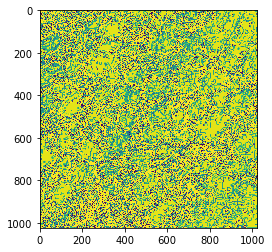

In [7]:
plt.imshow(lbp)

(array([ 53403.,  13536.,  23067.,   6353.,  14862.,  11491.,  33903.,
         23680.,  76446.,  23222.,  68425.,  43711.,  49729.,  22498.,
         50658.,  19616., 513976.]),
 array([ 0.        ,  1.47058824,  2.94117647,  4.41176471,  5.88235294,
         7.35294118,  8.82352941, 10.29411765, 11.76470588, 13.23529412,
        14.70588235, 16.17647059, 17.64705882, 19.11764706, 20.58823529,
        22.05882353, 23.52941176, 25.        ]),
 <a list of 17 Patch objects>)

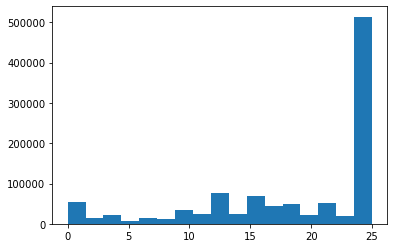

In [8]:
plt.hist(lbp.flatten(), bins= 17)

In [9]:
n_points = points
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

In [10]:
mask = np.logical_or.reduce([lbp == each for each in edge_labels])

In [11]:
# tmp = img.copy()
# tmp[~mask] = 0
# tmp[mask] = 255
# cv.imshow("img", img)
# cv.imshow("tmp", tmp)
# cv.waitKey(0)

In [12]:
wr, wb, wg, wc = 0.87433346,  0.99435252,  0.,          0.9
thres = 12
r = seg.RemoveBG(img, lbp, thres, 1000, wr, wg, wb, wc)
r2 = seg.RemoveBG(img2, lbp, thres, 1000, wr, wg, wb, wc)

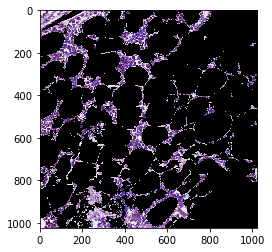

In [13]:
plt.imshow(r)

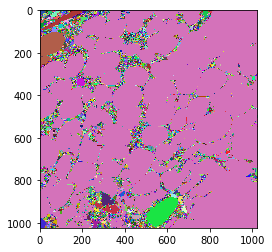

In [14]:
plt.imshow(seg.SegmentImage(img, lbp, thres, wr, wg, wb, wc))

In [15]:
lmap, reg = seg.RegionExtract(img, lbp, thres, wr, wg, wb, wc)

In [16]:
r_map = seg.GetBgMap(lmap, 1000, reg)

In [17]:
r_white = np.array(img)
r_white[r_map] = 255

In [18]:
gray = cv.cvtColor(r_white, cv.COLOR_BGR2GRAY)

In [19]:
r_nuclei = np.zeros_like(gray)
r_nuclei[gray<150] = 255

In [20]:
# cv.imshow("img", r_nuclei)
# cv.waitKey(0)

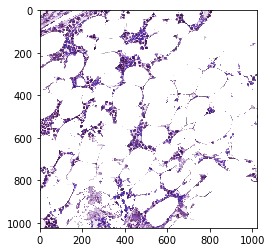

In [21]:
plt.imshow(r_white)

In [22]:
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

In [23]:
ret

183.0

In [24]:
r_white = np.array(img)
r_white[r_map] = 255

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_CLOSE,kernel, iterations = 2)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.2*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)

# # Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(r_white,markers)
# r_white[markers == -1] = [0, 255,0]

In [25]:
outline = np.zeros_like(markers, "uint8")
outline[markers == -1] = 255
outline[thresh == 255] = 255

In [26]:
# cv.imshow("img", outline)
# cv.waitKey(0)

In [27]:
# Copy the thresholded image.
out = outline.copy()

# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = outline.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

cv.floodFill(out, mask, (1,1), 255)

(907147, array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint8), (0, 0, 1024, 1024))

In [28]:
# cv.imshow("img", out)
# # cv.imshow("img2", opening)
# # cv.imshow("img3", thresh)

# cv.waitKey(0)

In [29]:
nuc_mask = np.ones_like(out) == 1
nuc_mask[markers == -1] = False

In [30]:
nuc_mask

array([[False, False, False, ..., False, False, False],
       [False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False],
       ...,
       [False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False],
       [False, False, False, ..., False, False, False]])

In [31]:
nuc_mask[markers == -1]

array([False, False, False, ..., False, False, False])

In [32]:
nuc_mask[gray>100] = False
nuc_mask[gray<10] = False

In [33]:
nuc_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [34]:
tmp = np.array(r_white, "uint8")

tmp[nuc_mask] = [0, 255, 0]

In [35]:
tmp2 = np.zeros_like(r_white, "uint8")

tmp2[nuc_mask] = r_white[nuc_mask]

segmented, reg = seg.RegionExtract(tmp2, np.zeros_like(lbp), 20, wr, wg, wb, 1)
noise = seg.GetBgMap(segmented, 20, reg)

tmp2[~noise] = 0

In [36]:
# tmp2[gray>100] = 0

In [37]:
cv.imshow("img", tmp2)
cv.imshow("out", img)
cv.imshow("img2", tmp)
cv.waitKey(0)

-1

In [1]:
import nuclei

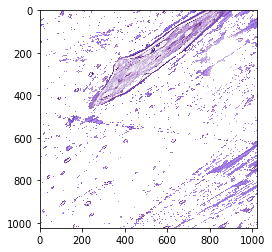

In [3]:
nuclei.run(r"D:\Project 2\Project_2\Dataset\P9_B34-22773-28922.jpg")